<a href="https://colab.research.google.com/github/venetisgr/batch_norm_tf_simple/blob/master/batch_norm_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading ...
epoch: 0 batch: 99 n_batches: 410 train cost: 0.22836465 acc: 0.94
epoch: 0 batch: 99 n_batches: 410 test cost: 0.31075293 acc: 0.91
epoch: 0 batch: 199 n_batches: 410 train cost: 0.25256193 acc: 0.93
epoch: 0 batch: 199 n_batches: 410 test cost: 0.22050574 acc: 0.94
epoch: 0 batch: 299 n_batches: 410 train cost: 0.15275054 acc: 0.96
epoch: 0 batch: 299 n_batches: 410 test cost: 0.17721395 acc: 0.95
epoch: 0 batch: 399 n_batches: 410 train cost: 0.2245172 acc: 0.93
epoch: 0 batch: 399 n_batches: 410 test cost: 0.16055837 acc: 0.96
epoch: 1 batch: 99 n_batches: 410 train cost: 0.08128071 acc: 0.99
epoch: 1 batch: 99 n_batches: 410 test cost: 0.14681305 acc: 0.96
epoch: 1 batch: 199 n_batches: 410 train cost: 0.0327673 acc: 1.00
epoch: 1 batch: 199 n_batches: 410 test cost: 0.13192873 acc: 0.96
epoch: 1 batch: 299 n_batches: 410 train cost: 0.20542088 acc: 0.93
epoch: 1 batch: 299 n_batches: 410 test cost: 0.13468891 acc: 0.97
epoch: 1 batch: 399 n_batches: 410 train cost: 0.

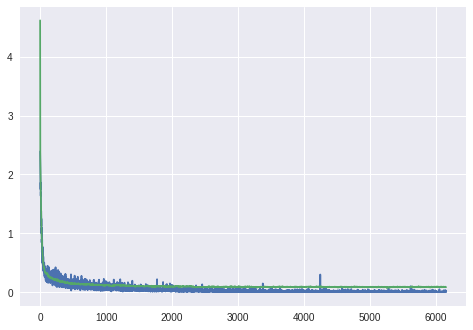

In [3]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle


def get_normalized_data():
    print("Reading ...")

    df = pd.read_csv('train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest = X[-1000:]
    Ytest = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std

    return Xtrain, Xtest, Ytrain, Ytest


def init_weight(M1, M2):  #weight initialization
    return np.random.randn(M1, M2) * np.sqrt(2.0 / M1)

#each class holds the values of each layer

class HiddenLayer(object):  #normal layer no dropout  #includes weights and biases
    def __init__(self, M1, M2):
        self.M1 = M1  #no of inputs/features
        self.M2 = M2   #no of layers

        W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)  #variable initialization
        b = np.zeros(M2)

        self.W = tf.Variable(W.astype(np.float32))  #convert them to tensors
        self.b = tf.Variable(b.astype(np.float32))

    def forward(self, X):  #receives the input X and calculates the output of the specific layer  X train. examples / features (r/c)
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)  #  X*weight +bias  #returns the activation of the specific layer

class HiddenLayerBatchNorm(object): #layer with dropout #includes weights ,beta term, gamma term , no need for bias since its included on beta term #Also included running/global mean and variance(weighted average)
    def __init__(self, M1, M2 ):  #running mean and  variance are needed for test forward
        self.M1 = M1 #no of inputs/features
        self.M2 = M2 #no of neurons

        W = init_weight(M1, M2).astype(np.float32)  #parameter initialization
        gamma = np.ones(M2).astype(np.float32)      #z= X*W
        beta = np.zeros(M2).astype(np.float32)      #zhat= beta*z + gamma

        self.W = tf.Variable(W)                     #converted to tensors
        self.gamma = tf.Variable(gamma)             #beta and gamma can be obtained via training (gradient descent)
        self.beta = tf.Variable(beta)               #running mean and var need to be updated on every iteration/forward but not via gradient descent

        # for test time
        #tensorflow by default assumes that all tf.variables are trainable(needed for cost function) thats why declare that mean and var are not trainable
        self.running_mean = tf.Variable(np.zeros(M2).astype(np.float32), trainable=False)  #mean initialized with zeros
        self.running_var = tf.Variable(np.zeros(M2).astype(np.float32), trainable=False)   #var  nitialized with ones
        # mean and var sizes are equal to the number of the neurons included on the hidden layer
        #we dont need to save mean and var since its dependent to each batch

    #we need to define if we are training in order to know which mean and var to use and to update them if needed
    def forward_with_batch(self, X, is_training,  decay=0.9):  # decay is needed for the global mean and var(weighted averages) is_training defines if we are training or testing
        z = tf.matmul(X, self.W)  # z same for both training and testing z=X*W

        # we have different forward in the case of training and a different one in the case of testing

        if is_training: #training , we need to update global mean and var and calculate the mean and var for the specific batch
            batch_mean, batch_var = tf.nn.moments(z, [0])  #moments return the mean and variance PER COLLUMN (axis=0) FOR THE SPECIFIC BATCH
            update_running_mean = tf.assign(  #needed for the update
                self.running_mean,            # term being updated
                self.running_mean * decay + batch_mean * (1 - decay)  #update is based on this function
            )
            update_running_var = tf.assign(
                self.running_var,
                self.running_var * decay + batch_var * (1 - decay)
            )

            with tf.control_dependencies([update_running_mean, update_running_var]): #this is where the update is happening
                out = tf.nn.batch_normalization( #output calculated (zhat)
                    z, #x*w
                    batch_mean, #batch specific mean
                    batch_var,  #batch specific var
                    self.beta,
                    self.gamma,
                    1e-4  #so we wont divide with zero
                )
                return tf.nn.relu(out)


        else: #testing #we dont calculate anything
            out = tf.nn.batch_normalization(  #calculates zhat(after batch norm) z-batch_norm-zhat-activation-output
                z, #x*w
                self.running_mean, #global mean
                self.running_var,  #global var
                self.beta,
                self.gamma,
                1e-4
            )
            return tf.nn.relu(out)


def ANN_forward(X,is_training): #layers is global
        out=X
        #for no in no_layers
        for h in layers[:-1]: #h "equals" the hidden layer class  #we need a seperate one for the last layers since its not implemented with batch norm
            out=h.forward_with_batch(out,is_training)
        logits = layers[-1].forward(out)
        return logits


def main ():


    # Data Extraction
    Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()
    Xtrain = Xtrain.astype(np.float32)
    Ytrain = Ytrain.astype(np.int32)
    Xtest = Xtest.astype(np.float32)
    Ytest = Ytest.astype(np.int32)

    learning_rate = 1e-2
    epochs = 15
    batch_sz = 100
    print_period = 100

    #Placeholder initialization
    N, D = Xtrain.shape
    tfX = tf.placeholder(tf.float32, [None,D], name='tfX')
    tfY = tf.placeholder(tf.int32, [None,], name='tfY')

    #hidden layers initialization

    no_of_hidden_layers=3 #+1 for the final layer
    hidden_layers_size=[500,400]  #without final layer

    N, D = Xtrain.shape
    M1=D

    global layers
    layers = [] #holds our hidden layer classes  #global since we want to update our layers outside main
    # hidden layers initialization
    for M2 in hidden_layers_size:  #m2 is the number of neurons
        h=HiddenLayerBatchNorm(M1,M2)
        layers.append(h) #holds our hidden layer classes
        M1=M2

    # final layer
    K = len(set(Ytrain))  # set is acollection of unique elements #thus it shows us the number (of unique) classes
    h = HiddenLayer(M1 , K)
    layers.append(h)

    #training
    #to be used inside session

    logits=ANN_forward(tfX,True) #1 since we are training

    cost = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits( #sparse doesnt need one-hot encoding
            logits=logits,
            labels=tfY
        )
    )



    #train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    # train_op = tf.train.RMSPropOptimizer(learning_rate, decay=0.99, momentum=0.9).minimize(cost)
    train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(cost)
    # train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

    #testing
    test_logits=ANN_forward(Xtest,0) #0 since we are training

    cost_tr = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(  # sparse doesnt need one-hot encoding
            logits=test_logits,
            labels=Ytest
        )
     )
    predict_op = tf.argmax(logits, 1)
    predict_op_tr = tf.argmax(test_logits, 1)

    n_batches = N // batch_sz
    costs = []
    test_cost=[]

    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for i in range(epochs):
            Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
            for j in range(n_batches):
                Xbatch = Xtrain[j * batch_sz:(j * batch_sz + batch_sz),:]
                Ybatch = Ytrain[j * batch_sz:(j * batch_sz + batch_sz)]

                session.run(logits, feed_dict={tfX: Xbatch })

                session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                c=session.run(cost , feed_dict={tfX: Xbatch, tfY: Ybatch})
                c2 = session.run(cost_tr)
                costs.append(c)
                test_cost.append(c2)

                if (j + 1) % print_period == 0:
                    session.run(test_logits)

                    p1=session.run(predict_op, feed_dict={tfX: Xbatch})
                    p2=session.run(predict_op_tr)

                    acc1=np.mean(Ybatch == p1)
                    acc2=np.mean(Ytest == p2)


                    print("epoch:", i, "batch:", j, "n_batches:", n_batches, "train cost:", c, "acc: %.2f" % acc1)
                    print("epoch:", i, "batch:", j, "n_batches:", n_batches, "test cost:", c2, "acc: %.2f" % acc2)



        #print("Train acc:", self.score(X, Y), "Test acc:", self.score(Xtest, Ytest))
        plt.plot(costs)
        plt.plot(test_cost)
        plt.show()

    #print final score and acc
if __name__ == '__main__':
    main()



